In [ ]:
# Enable autoreload extension
%load_ext autoreload

# Reload all modules before executing a new line of code
%autoreload 2

In [ ]:
import sys
from pathlib import Path

here = Path.cwd().resolve()
repo_root = here if (here / "src").exists() else here.parents[1]

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

In [1]:
import tiktoken
import torch
#from src.gpt_blocks.gpt_model import DummyGPTModel

ModuleNotFoundError: No module named 'tiktoken'

In [ ]:
# Gpt config
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "embed_dim": 768,
    "n_layers": 12,
    "n_heads": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

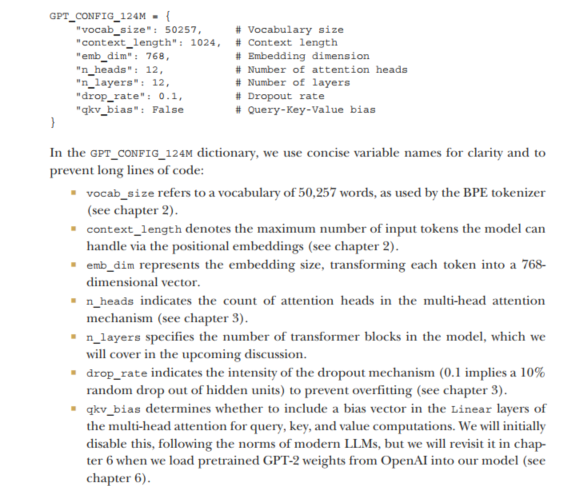

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []

txt1 = "Every effort moves you"
txt2 = "Everyday holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

In [ ]:
batch = torch.stack(batch, dim=0)  # (batch_size, seq_length)
print("Batch shape:", batch.shape)
print("Batch:", batch)

## Layer normalization
converting the activations of a layer to zero mean unit variance

In [ ]:
import torch.nn as nn
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

In [ ]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:", mean)
print("Variance:", var)

In [ ]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

In [ ]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

In [ ]:
from src.gpt_blocks.layer_norm import LayerNorm

In [ ]:
ln = LayerNorm(embed_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

In [ ]:
from src.gpt_blocks.activation_function import GELU
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from src.gpt_blocks.nueral_network import FeedForward

In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.randn(2, 3, GPT_CONFIG_124M["embed_dim"])
out = ffn(x)
print("Output shape:", out.shape)

### Below code is for deep nueral network

In [30]:
class ExampleDeepNueralNetwork(nn.Module):
    def __init__(self, layer_sizes, uses_shortcut):
        super().__init__()
        self.uses_shortcut = uses_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[i], layer_sizes[i+1]), GELU())
        for i in range(len(layer_sizes) - 1)])
    
    def forward(self, x):
        for layer in self.layers:
            if self.uses_shortcut:
                x = x + layer(x)
            else:
                x = layer(x)
        return x

In [31]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.0, 0.0, -1.0]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNueralNetwork(layer_sizes, uses_shortcut=False)

In [32]:
output = model_without_shortcut(sample_input)
target = torch.tensor([[0.0]])

loss = nn.MSELoss()(output, target)
loss.backward()

for name, param in model_without_shortcut.named_parameters():
    if "weight" in name:
        print(f"Gradient for {name}:\n{param.grad.abs().mean().item()}")

Gradient for layers.0.0.weight:
0.00020173590746708214
Gradient for layers.1.0.weight:
0.0001201116101583466
Gradient for layers.2.0.weight:
0.0007152042235247791
Gradient for layers.3.0.weight:
0.0013988739810883999
Gradient for layers.4.0.weight:
0.00504964729771018


In [33]:
model = ExampleDeepNueralNetwork(layer_sizes, uses_shortcut=True)
output = model(sample_input)
target = torch.tensor([[0.0]])

loss = nn.MSELoss()(output, target)
loss.backward()

for name, param in model.named_parameters():
    if "weight" in name:
        print(f"Gradient for {name}:\n{param.grad.abs().mean().item()}")

Gradient for layers.0.0.weight:
0.6176860928535461
Gradient for layers.1.0.weight:
0.16023141145706177
Gradient for layers.2.0.weight:
0.3973105847835541
Gradient for layers.3.0.weight:
0.446980357170105
Gradient for layers.4.0.weight:
1.3971573114395142


In [34]:
# Gpt config
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "embed_dim": 768,
    "n_layers": 12,
    "n_heads": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [35]:
from src.gpt_blocks.gpt_model import TransformerBlock

In [36]:
torch.manual_seed(123)
x = torch.randn(2,4,768)
block = TransformerBlock(GPT_CONFIG_124M)
out = block(x)

In [37]:
print("input shape:", x.shape)
print("output shape:", out.shape)

input shape: torch.Size([2, 4, 768])
output shape: torch.Size([2, 4, 768])


In [38]:
from src.gpt_blocks.gpt_model import GPTModel

In [39]:
model = GPTModel(GPT_CONFIG_124M)

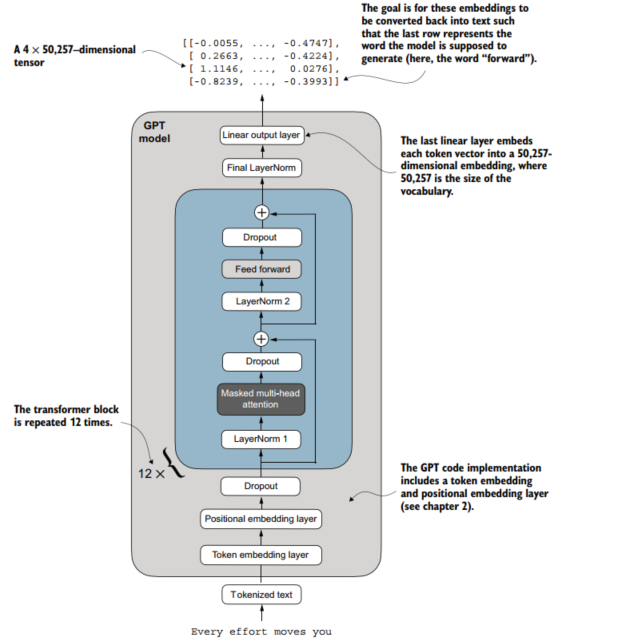

In [40]:
out = model(batch)
print("input shape:", batch.shape)
print("output shape:", out.shape)
print(out)

input shape: torch.Size([2, 4])
output shape: torch.Size([2, 4, 50257])
tensor([[[    -0.3097,     -0.3676,     -0.2067,  ...,     -0.0617,
               0.1507,      0.2199],
         [    -0.5830,     -0.2453,     -0.1815,  ...,      0.0003,
              -0.1746,      1.8551],
         [    -1.3241,     -0.6532,     -0.5867,  ...,      0.3404,
               0.2660,      0.1188],
         [    -0.0438,      0.3075,      0.3221,  ...,      0.7968,
               0.7497,     -0.4595]],

        [[    -0.6213,     -0.3092,     -0.5123,  ...,      0.3197,
               0.5231,      0.3969],
         [     0.2546,     -0.5407,      0.1618,  ...,      0.5942,
               0.9633,      1.0222],
         [    -0.4519,     -0.2579,     -0.5349,  ...,      0.5699,
               0.2825,     -0.0037],
         [    -0.1648,     -0.7586,      0.1282,  ...,      0.5769,
               0.8738,     -0.5774]]], grad_fn=<UnsafeViewBackward0>)


In [41]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in the model: {total_params:,}")

Total parameters in the model: 163,009,536


In [43]:
print("Token embedding layer shape:", model.token_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])
